## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.metrics import confusion_matrix
from sklearn import svm
import datetime


## Importing the data, null ,describe and conversion of datatypes

In [3]:
os.chdir('C:/Users/soumya/Desktop/BI/Soumya - Projects')
df = pd.read_csv('Fraud Detection.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76529 entries, 0 to 76528
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_number        76529 non-null  int64  
 1   user_id                   76529 non-null  int64  
 2   payment_method            76529 non-null  object 
 3   partner_id                76529 non-null  int64  
 4   partner_category          76529 non-null  object 
 5   country                   76529 non-null  object 
 6   device_type               76529 non-null  object 
 7   money_transacted          76529 non-null  float64
 8   transaction_initiation    76529 non-null  object 
 9   partner_pricing_category  76529 non-null  int64  
 10  is_fraud                  76529 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 6.4+ MB
None


In [4]:
print(df.isna().sum())

transaction_number          0
user_id                     0
payment_method              0
partner_id                  0
partner_category            0
country                     0
device_type                 0
money_transacted            0
transaction_initiation      0
partner_pricing_category    0
is_fraud                    0
dtype: int64


In [5]:
df['partner_id'] = df['partner_id'].astype('category')
df['partner_pricing_category'] = df['partner_pricing_category'].astype('category')
df['user_id'] = df['user_id'].astype('object')
df['transaction_number'] = df['transaction_number'].astype('object')
df['transaction_initiation'] = pd.to_datetime(df['transaction_initiation'], infer_datetime_format=True)


In [6]:
df.describe()

,money_transacted,is_fraud
count,76529.000000,76529.000000
mean,132.724348,0.002012
std,2350.110900,0.044814
min,-20000.000000,0.000000
25%,-1.000000,0.000000
50%,20.000000,0.000000
75%,52.000000,0.000000
max,197217.760000,1.000000


In [7]:
df.nunique()

transaction_number          76529
user_id                      3594
payment_method                  6
partner_id                     23
partner_category                9
country                         1
device_type                     4
money_transacted             1454
transaction_initiation      75811
partner_pricing_category        4
is_fraud                        2
dtype: int64

## Data Visulaization

In [8]:
print(df.head())
print(df.shape)

  transaction_number   user_id          payment_method partner_id  \
0       144703125000  17539344  sbi_atm_cum_debit_card      47334   
1     77406814453032  24710841       e_wallet_payments      78890   
2    308929485482801  24265476       e_wallet_payments      78890   
3    665270027747073  10240000       other_debit_cards     102557   
4     38276160171101   5880625       other_debit_cards     118335   

  partner_category  country      device_type  money_transacted  \
0            cat_1  IND_INR  android_devices              -5.0   
1            cat_2  IND_INR        other_pcs             100.0   
2            cat_2  IND_INR        other_pcs              50.0   
3            cat_3  IND_INR        other_pcs            1000.0   
4            cat_1  IND_INR        other_pcs             200.0   

     transaction_initiation partner_pricing_category  is_fraud  
0 2016-11-15 19:16:12+00:00                        2         0  
1 2017-01-11 09:25:33+00:00                        2      

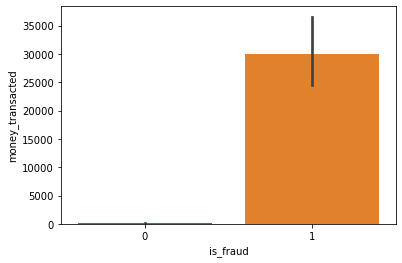

AxesSubplot(0.125,0.125;0.775x0.755)
Total number of fraud 154


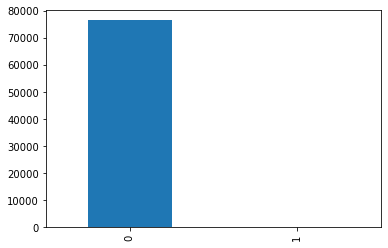

In [9]:
sns.barplot(x='is_fraud', y="money_transacted", data=df, estimator=np.mean)
sns.color_palette("Set2")
plt.show()

df.groupby('is_fraud').mean()

print(df['is_fraud'].value_counts().plot(kind='bar'))
# heavily imbalaned class . how to deal with it?

a = df['is_fraud'].sum()
print('Total number of fraud', a)
plt.show()

Text(0.5, 1.0, 'Money_transacted vs. fraud')

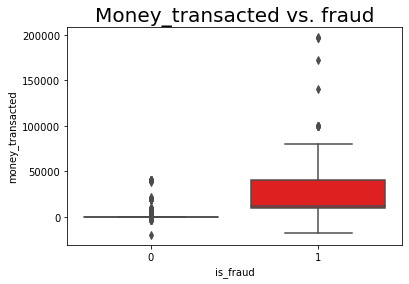

In [10]:
sns.boxplot(
    data=df,
    x='is_fraud',
    y='money_transacted',
    color='red')
plt.title("Money_transacted vs. fraud", size=20)

In [11]:
df['Hours'] = pd.DatetimeIndex(df['transaction_initiation']).hour
df['day'] = pd.DatetimeIndex(df['transaction_initiation']).day
df['Hours'] = df['Hours'].astype('object')
df['day'] = df['day'].astype('object')

## Multivariate Analysis

In [12]:
print("Mean feature values per payment method",df.groupby('payment_method')['money_transacted','is_fraud'].mean())

Mean feature values per payment method                             money_transacted  is_fraud
payment_method                                        
e_wallet_payments                  74.483094  0.000073
other_debit_cards                 826.844872  0.009566
sbi_atm_cum_debit_card            -77.824620  0.000164
unified_payments_interface         29.200000  0.000000
visa_master_credit_cards          872.432934  0.021597
visa_master_debit_cards           398.193655  0.004380


<ipython-input-12-25b0b1904279>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Mean feature values per payment method",df.groupby('payment_method')['money_transacted','is_fraud'].mean())


In [13]:
df['Fraud_Label'] = ['fraud' if x == 1 else 'Not_fraud' for x in df['is_fraud']]

In [14]:
part_df = pd.DataFrame ({'pay_method': df.groupby(['partner_category', 'Fraud_Label'] ) ["transaction_number"].nunique()})
partner_pivot = pd.pivot_table(part_df, values = 'pay_method', index = ['partner_category'], columns = ['Fraud_Label']).reset_index().rename(columns={'Fraud_Label':'Category','Not_fraud':'Not_fraud','fraud':'fraud'})
partner_pivot['fraud'].fillna(0, inplace = True)
partner_pivot['partner_percentage']= (partner_pivot['fraud']/(partner_pivot['fraud']+partner_pivot['Not_fraud']))*100
partner_pivot['total_trans'] = (partner_pivot['fraud']+ partner_pivot['Not_fraud'])
partner_pivot['percent_trans'] = (partner_pivot['total_trans']/ partner_pivot['total_trans'].sum())*100
                                  
partner_pivot['count_of_fraud'] = (partner_pivot['percent_trans']*partner_pivot['partner_percentage'])/100      


partner_pivot = partner_pivot.reset_index().rename_axis(None, axis=1)

partner_pivot


,index,partner_category,Not_fraud,fraud,partner_percentage,total_trans,percent_trans,count_of_fraud
0,0,cat_1,36178.0,128.0,0.352559,36306.0,47.440839,0.167257
1,1,cat_2,36004.0,15.0,0.041645,36019.0,47.065818,0.019600
2,2,cat_3,1527.0,9.0,0.585938,1536.0,2.007082,0.011760
3,3,cat_4,1310.0,0.0,0.000000,1310.0,1.711769,0.000000
4,4,cat_5,1026.0,0.0,0.000000,1026.0,1.340668,0.000000
5,5,cat_6,146.0,0.0,0.000000,146.0,0.190777,0.000000
6,6,cat_7,165.0,0.0,0.000000,165.0,0.215605,0.000000
7,7,cat_8,17.0,2.0,10.526316,19.0,0.024827,0.002613
8,8,cat_9,2.0,0.0,0.000000,2.0,0.002613,0.000000


Text(0.5, 1.0, 'Partner Category v/s Fraud_Percentage')

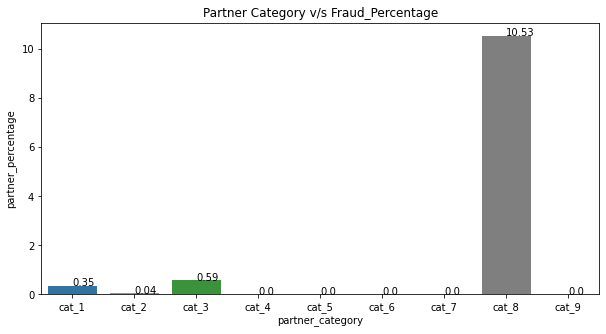

In [15]:
plt.figure(figsize=(10,5))

bar_chart = sns.barplot(x = "partner_category", y = "partner_percentage", data = partner_pivot)
for index, row in partner_pivot.iterrows():
    bar_chart.text(row.name , row.partner_percentage, round(row.partner_percentage,2))
plt.title('Partner Category v/s Fraud_Percentage')


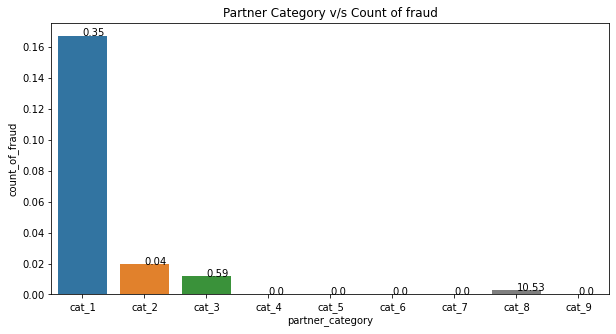

In [16]:
plt.figure(figsize=(10,5))

bar_chart = sns.barplot(x = "partner_category", y = "count_of_fraud", data = partner_pivot)
for index, row in partner_pivot.iterrows():
    bar_chart.text(row.name , row.count_of_fraud, round(row.partner_percentage,2))
plt.title('Partner Category v/s Count of fraud')

plt.show()

In [17]:
payment_df = pd.DataFrame ({'pay_method': df.groupby(['payment_method', 'Fraud_Label'] ) ["transaction_number"].nunique()})
payment_pivot = pd.pivot_table(payment_df, values = 'pay_method', index = ['payment_method'], columns = ['Fraud_Label']).reset_index().rename(columns={'Fraud_Label':'pay_method','Not_fraud':'Not_fraud','fraud':'fraud'})
payment_pivot['fraud'].fillna(0, inplace = True)
payment_pivot['payment_percentage']= (payment_pivot['fraud']/(payment_pivot['fraud']+payment_pivot['Not_fraud']))*100
payment_pivot['total_trans'] = (payment_pivot['fraud']+ payment_pivot['Not_fraud'])
payment_pivot['percent_trans'] = (payment_pivot['total_trans']/ payment_pivot['total_trans'].sum())*100
                                  
payment_pivot['count_of_fraud'] = (payment_pivot['percent_trans']*payment_pivot['payment_percentage'])/100      


payment_pivot = payment_pivot.reset_index().rename_axis(None, axis=1)

payment_pivot

,index,payment_method,Not_fraud,fraud,payment_percentage,total_trans,percent_trans,count_of_fraud
0,0,e_wallet_payments,27382.0,2.0,0.007304,27384.0,35.782514,0.002613
1,1,other_debit_cards,4452.0,43.0,0.956618,4495.0,5.873590,0.056188
2,2,sbi_atm_cum_debit_card,30533.0,5.0,0.016373,30538.0,39.903827,0.006533
3,3,unified_payments_interface,15.0,0.0,0.000000,15.0,0.019600,0.000000
4,4,visa_master_credit_cards,2401.0,53.0,2.159739,2454.0,3.206628,0.069255
5,5,visa_master_debit_cards,11592.0,51.0,0.438031,11643.0,15.213841,0.066641


Text(0.5, 1.0, 'payment_method v/s Fraud_Percentage')

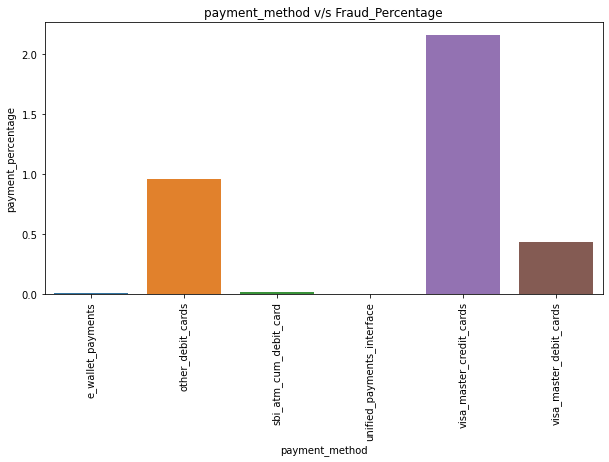

In [18]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_2_chart = sns.barplot(x = "payment_method", y = "payment_percentage", data = payment_pivot)
for index, row in payment_pivot.iterrows():
    bar_chart.text(row.index , row.payment_method, round(row.payment_percentage,2))
plt.title('payment_method v/s Fraud_Percentage')


Text(0.5, 1.0, 'payment_method v/s Fraud_Percentage')

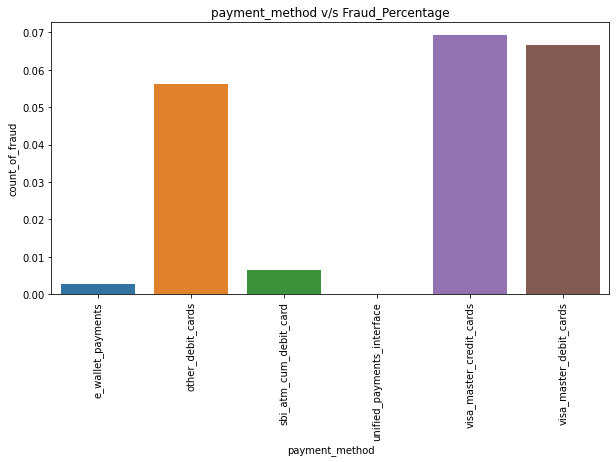

In [19]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_2_chart = sns.barplot(x = "payment_method", y = "count_of_fraud", data = payment_pivot)
for index, row in payment_pivot.iterrows():
    bar_chart.text(row.index , row.payment_method, round(row.count_of_fraud,2))
plt.title('payment_method v/s Fraud_Percentage')

In [20]:
device_df = pd.DataFrame ({'dev_method': df.groupby(['device_type', 'Fraud_Label'] ) ["transaction_number"].nunique()})
device_pivot = pd.pivot_table(device_df, values = 'dev_method', index = ['device_type'], columns = ['Fraud_Label']).reset_index().rename(columns={'Fraud_Label':'device_type','Not_fraud':'Not_fraud','fraud':'fraud'})
device_pivot['fraud'].fillna(0, inplace = True)
device_pivot['device_percentage']= (device_pivot['fraud']/(device_pivot['fraud']+device_pivot['Not_fraud']))*100
device_pivot['total_trans'] = (device_pivot['fraud']+ device_pivot['Not_fraud'])
device_pivot['percent_trans'] = (device_pivot['total_trans']/ device_pivot['total_trans'].sum())*100
                                  
device_pivot['count_of_fraud'] = (device_pivot['percent_trans']*device_pivot['device_percentage'])/100      


device_pivot = device_pivot.reset_index().rename_axis(None, axis=1)

device_pivot

,index,device_type,Not_fraud,fraud,device_percentage,total_trans,percent_trans,count_of_fraud
0,0,android_devices,29657.0,5.0,0.016857,29662.0,38.759163,0.006533
1,1,ios_devices,876.0,0.0,0.000000,876.0,1.144664,0.000000
2,2,other_pcs,45415.0,145.0,0.318262,45560.0,59.532987,0.189471
3,3,windows_pcs,427.0,4.0,0.928074,431.0,0.563185,0.005227


Text(0.5, 1.0, 'device_type v/s Fraud_Percentage')

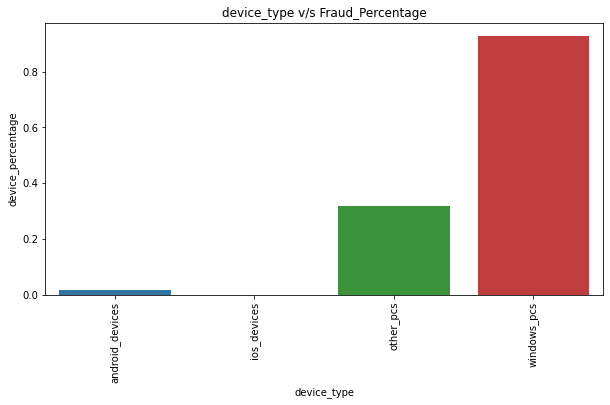

In [21]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_3_chart = sns.barplot(x = "device_type", y = "device_percentage", data = device_pivot)
for index, row in device_pivot.iterrows():
    bar_chart.text(row.index , row.device_type, round(row.device_percentage,2))
plt.title('device_type v/s Fraud_Percentage')

Text(0.5, 1.0, 'device-type v/s count_of_fraud')

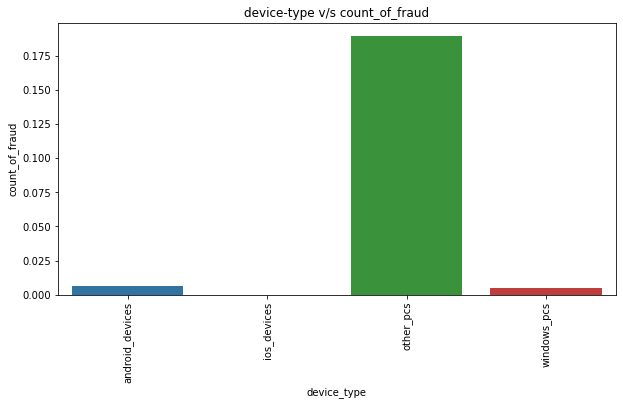

In [22]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_2_chart = sns.barplot(x = "device_type", y = "count_of_fraud", data = device_pivot)
for index, row in device_pivot.iterrows():
    bar_chart.text(row.index , row.device_type, round(row.count_of_fraud,2))
plt.title('device-type v/s count_of_fraud')

In [23]:
hour_df = pd.DataFrame ({'hour': df.groupby(['Hours', 'Fraud_Label'] ) ["transaction_number"].nunique()})
hours_pivot = pd.pivot_table(hour_df, values = 'hour', index = ['Hours'], columns = ['Fraud_Label']).reset_index().rename(columns={'Fraud_Label':'hours','Not_fraud':'Not_fraud','fraud':'fraud'})
hours_pivot['fraud'].fillna(0, inplace = True)
hours_pivot['hour_percentage']= (hours_pivot['fraud']/(hours_pivot['fraud']+hours_pivot['Not_fraud']))*100
hours_pivot['total_trans'] = (hours_pivot['fraud']+ hours_pivot['Not_fraud'])
hours_pivot['percent_trans'] = (hours_pivot['total_trans']/ hours_pivot['total_trans'].sum())*100
                                  
hours_pivot['count_of_fraud'] = (hours_pivot['percent_trans']*hours_pivot['hour_percentage'])/100      


hours_pivot = hours_pivot.reset_index().rename_axis(None, axis=1)

hours_pivot.head()

,index,Hours,Not_fraud,fraud,hour_percentage,total_trans,percent_trans,count_of_fraud
0,0,0,132.0,1.0,0.751880,133.0,0.173790,0.001307
1,1,1,141.0,0.0,0.000000,141.0,0.184244,0.000000
2,2,2,231.0,0.0,0.000000,231.0,0.301846,0.000000
3,3,3,569.0,6.0,1.043478,575.0,0.751349,0.007840
4,4,4,1841.0,0.0,0.000000,1841.0,2.405624,0.000000


Text(0.5, 1.0, 'Hours v/s Fraud_Percentage')

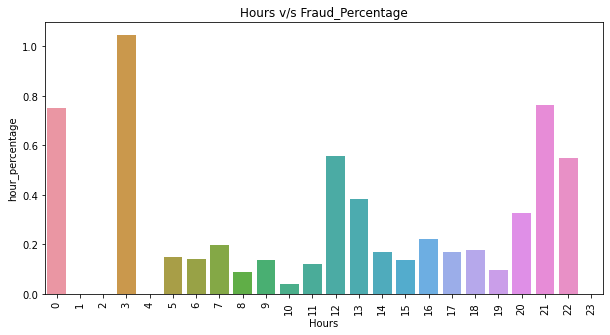

In [24]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_3_chart = sns.barplot(x = "Hours", y = "hour_percentage", data = hours_pivot)
for index, row in hours_pivot.iterrows():
    bar_chart.text(row.index , row.Hours, round(row.hour_percentage,2))
plt.title('Hours v/s Fraud_Percentage')

Text(0.5, 1.0, 'Hours v/s count_of_fraud')

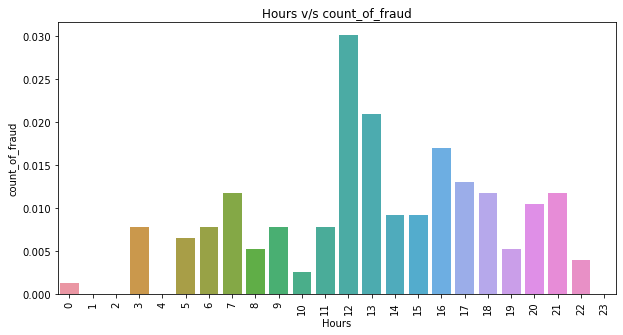

In [25]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_2_chart = sns.barplot(x = "Hours", y = "count_of_fraud", data = hours_pivot)
for index, row in hours_pivot.iterrows():
    bar_chart.text(row.index , row.Hours, round(row.count_of_fraud,2))
plt.title('Hours v/s count_of_fraud')

In [26]:
Day_df = pd.DataFrame ({'day_df': df.groupby(['day', 'Fraud_Label'] ) ["transaction_number"].nunique()})
day_pivot = pd.pivot_table(Day_df, values = 'day_df', index = ['day'], columns = ['Fraud_Label']).reset_index().rename(columns={'Fraud_Label':'day','Not_fraud':'Not_fraud','fraud':'fraud'})
day_pivot['fraud'].fillna(0, inplace = True)
day_pivot['day_percentage']= (day_pivot['fraud']/(day_pivot['fraud']+day_pivot['Not_fraud']))*100
day_pivot['total_trans'] = (day_pivot['fraud']+ day_pivot['Not_fraud'])
day_pivot['percent_trans'] = (day_pivot['total_trans']/ day_pivot['total_trans'].sum())*100
                                  
day_pivot['count_of_fraud'] = (day_pivot['percent_trans']*day_pivot['day_percentage'])/100      


day_pivot = day_pivot.reset_index().rename_axis(None, axis=1)

day_pivot.head()

,index,day,Not_fraud,fraud,day_percentage,total_trans,percent_trans,count_of_fraud
0,0,1,3546.0,18.0,0.505051,3564.0,4.657058,0.023520
1,1,2,1479.0,5.0,0.336927,1484.0,1.939134,0.006533
2,2,3,1829.0,1.0,0.054645,1830.0,2.391250,0.001307
3,3,4,3684.0,13.0,0.351636,3697.0,4.830848,0.016987
4,4,5,1751.0,0.0,0.000000,1751.0,2.288022,0.000000


Text(0.5, 1.0, 'day v/s day_percentage')

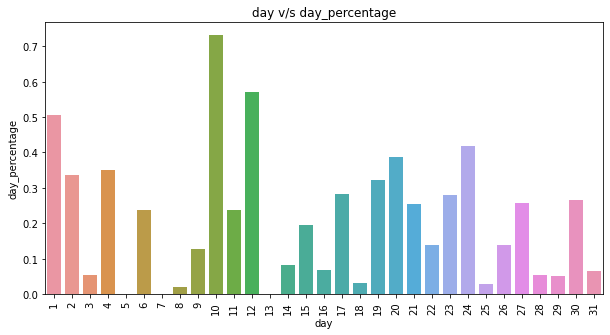

In [27]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_3_chart = sns.barplot(x = "day", y = "day_percentage", data = day_pivot)
for index, row in day_pivot.iterrows():
    bar_chart.text(row.index , row.day, round(row.day_percentage,2))
plt.title('day v/s day_percentage')

Text(0.5, 1.0, 'day v/s count_of_fraud')

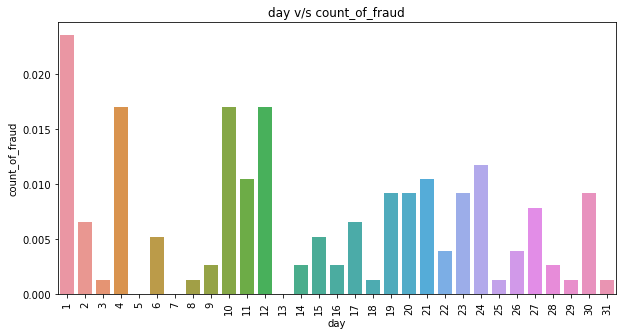

In [28]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

bar_3_chart = sns.barplot(x = "day", y = "count_of_fraud", data = day_pivot)
for index, row in day_pivot.iterrows():
    bar_chart.text(row.index , row.day, round(row.count_of_fraud,2))
plt.title('day v/s count_of_fraud')

## Money transacted - distribution , credited, debited

AxesSubplot(0.125,0.125;0.775x0.755)


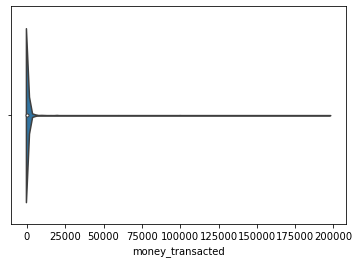

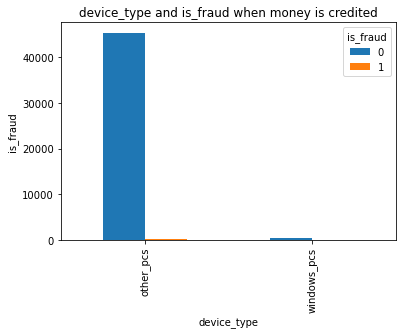

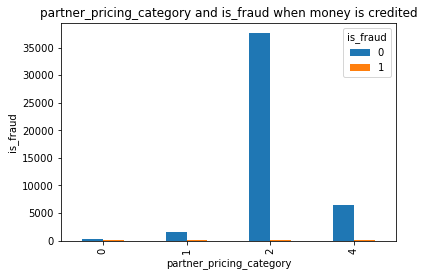

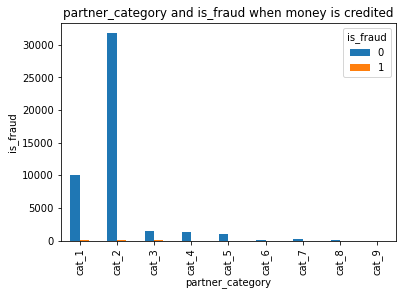

In [29]:
df_positive = df[df.money_transacted >= 0]

print(sns.violinplot(df_positive.money_transacted))


pd.crosstab(df_positive.device_type,df_positive.is_fraud).plot(kind='bar')
plt.title('device_type and is_fraud when money is credited')
plt.xlabel('device_type')
plt.ylabel('is_fraud')
plt.show()

pd.crosstab(df_positive.partner_pricing_category,df_positive.is_fraud).plot(kind='bar')
plt.title('partner_pricing_category and is_fraud when money is credited')
plt.xlabel('partner_pricing_category')
plt.ylabel('is_fraud')
plt.show()

pd.crosstab(df_positive.partner_category,df_positive.is_fraud).plot(kind='bar')
plt.title('partner_category and is_fraud when money is credited')
plt.xlabel('partner_category')
plt.ylabel('is_fraud')
plt.show()




AxesSubplot(0.125,0.125;0.775x0.755)


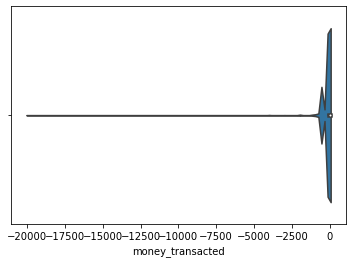

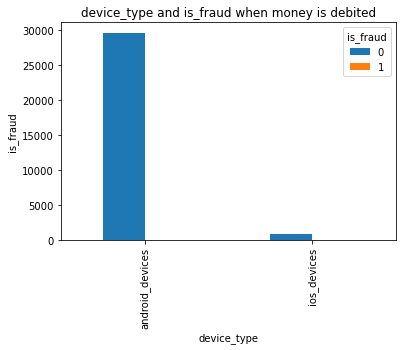

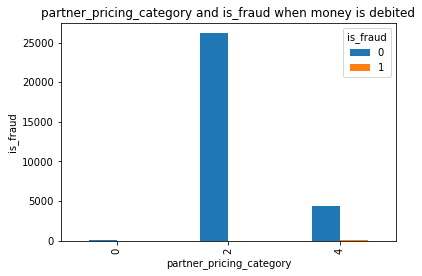

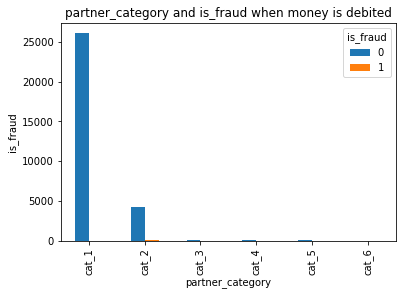

In [30]:
df_negative = df[df.money_transacted <= 0]

print(sns.violinplot(df_negative.money_transacted))


pd.crosstab(df_negative.device_type,df_negative.is_fraud).plot(kind='bar')
plt.title('device_type and is_fraud when money is debited')
plt.xlabel('device_type')
plt.ylabel('is_fraud')
plt.show()

pd.crosstab(df_negative.partner_pricing_category,df_negative.is_fraud).plot(kind='bar')
plt.title('partner_pricing_category and is_fraud when money is debited')
plt.xlabel('partner_pricing_category')
plt.ylabel('is_fraud')
plt.show()

pd.crosstab(df_negative.partner_category,df_negative.is_fraud).plot(kind='bar')
plt.title('partner_category and is_fraud when money is debited')
plt.xlabel('partner_category')
plt.ylabel('is_fraud')
plt.show()




## Separating out numerical and categorical attributes


In [31]:
cat_attr = list(df.select_dtypes(include=['category','object']).columns)
num_attr = list(df.select_dtypes(include=['number']).columns)

print(cat_attr)
print(num_attr)

['transaction_number', 'user_id', 'payment_method', 'partner_id', 'partner_category', 'country', 'device_type', 'partner_pricing_category', 'Hours', 'day', 'Fraud_Label']
['money_transacted', 'is_fraud']


## Removing irrelevant columns and splitting into Train and Test


In [32]:
from sklearn.model_selection import train_test_split
X = df.drop(['is_fraud','transaction_number','user_id','transaction_initiation','country','Fraud_Label'], axis=1)
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, stratify = y)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.997996
1    0.002004
Name: is_fraud, dtype: float64
0    0.997962
1    0.002038
Name: is_fraud, dtype: float64


## Separating out numerical and categorical attributes


In [33]:
cat_attr = list(X_train.select_dtypes(include=['category','object']).columns)
num_attr = list(X_train.select_dtypes(include=['number']).columns)

print(cat_attr)
print(num_attr)

['payment_method', 'partner_id', 'partner_category', 'device_type', 'partner_pricing_category', 'Hours', 'day']
['money_transacted']


## OHE & Standard scaling

In [34]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
ohe = OneHotEncoder(handle_unknown='error')

ohe.fit(X_train[cat_attr])

columns_ohe = list(ohe.get_feature_names(cat_attr))
print(columns_ohe)

X_train_cat = ohe.transform(X_train[cat_attr])
X_test_cat = ohe.transform(X_test[cat_attr])

X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=columns_ohe)
X_test_cat = pd.DataFrame(X_test_cat.todense(), columns=columns_ohe)

['payment_method_e_wallet_payments', 'payment_method_other_debit_cards', 'payment_method_sbi_atm_cum_debit_card', 'payment_method_unified_payments_interface', 'payment_method_visa_master_credit_cards', 'payment_method_visa_master_debit_cards', 'partner_id_7889', 'partner_id_15778', 'partner_id_23667', 'partner_id_31556', 'partner_id_39445', 'partner_id_47334', 'partner_id_55223', 'partner_id_63112', 'partner_id_71001', 'partner_id_78890', 'partner_id_86779', 'partner_id_94668', 'partner_id_102557', 'partner_id_110446', 'partner_id_118335', 'partner_id_126224', 'partner_id_149891', 'partner_id_157780', 'partner_id_165669', 'partner_id_173558', 'partner_id_181447', 'partner_id_189336', 'partner_id_213003', 'partner_category_cat_1', 'partner_category_cat_2', 'partner_category_cat_3', 'partner_category_cat_4', 'partner_category_cat_5', 'partner_category_cat_6', 'partner_category_cat_7', 'partner_category_cat_8', 'partner_category_cat_9', 'device_type_android_devices', 'device_type_ios_devi

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num_attr])

X_train_std = pd.DataFrame(scaler.transform(X_train[num_attr]), columns=num_attr)
X_test_std = pd.DataFrame(scaler.transform(X_test[num_attr]), columns=num_attr)

In [36]:
X_train_preprocessed = pd.concat([X_train_std, X_train_cat], axis=1)
X_test_preprocessed = pd.concat([X_test_std, X_test_cat], axis=1)
X_train_preprocessed.head()

,money_transacted,payment_method_e_wallet_payments,payment_method_other_debit_cards,payment_method_sbi_atm_cum_debit_card,payment_method_unified_payments_interface,payment_method_visa_master_credit_cards,payment_method_visa_master_debit_cards,partner_id_7889,partner_id_15778,partner_id_23667,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,-0.048376,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.046175,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.057009,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.163481,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.041799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## OVERSAMPLING with SMOTE

In [37]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train_preprocessed, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 



After OverSampling, the shape of train_X: (114562, 102)
After OverSampling, the shape of train_y: (114562,) 

After OverSampling, counts of label '1': 57281
After OverSampling, counts of label '0': 57281


## LOGISTIC REGRESSION

In [38]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()

lg.fit(X_train_res,y_train_res)

y_train_pred = lg.predict(X_train_res)
y_test_pred = lg.predict(X_test_preprocessed)


print(y_train_pred)
print(y_test_pred)

[0 0 0 ... 1 1 1]
[0 0 0 ... 0 0 0]


C:\Users\soumya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19094
           1       0.12      0.90      0.21        39

    accuracy                           0.99     19133
   macro avg       0.56      0.94      0.60     19133
weighted avg       1.00      0.99      0.99     19133



In [40]:
## Feature Importance
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(lg)
smf.fit(X_train_preprocessed,y_train)
features = smf.get_support()
feature_name = X_train_preprocessed.columns[features]
feature_name

Index(['money_transacted', 'payment_method_e_wallet_payments',
       'payment_method_sbi_atm_cum_debit_card',
       'payment_method_visa_master_credit_cards', 'partner_id_23667',
       'partner_id_39445', 'partner_id_47334', 'partner_id_71001',
       'partner_id_78890', 'partner_id_102557', 'partner_id_118335',
       'partner_id_173558', 'partner_category_cat_2', 'partner_category_cat_3',
       'partner_category_cat_5', 'partner_category_cat_8',
       'device_type_windows_pcs', 'partner_pricing_category_1',
       'partner_pricing_category_4', 'Hours_0', 'Hours_4', 'Hours_6',
       'Hours_10', 'Hours_12', 'Hours_13', 'Hours_21', 'day_1', 'day_3',
       'day_4', 'day_5', 'day_7', 'day_9', 'day_10', 'day_13', 'day_16',
       'day_17', 'day_18', 'day_20', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_28'],
      dtype='object')

## RandomForestClassifier 

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
rf_model.fit(X_train_res, y_train_res)

y_train_pred = rf_model.predict(X_train_res)
y_test_pred = rf_model.predict(X_test_preprocessed)
print(y_train_pred)
print(y_test_pred)

[0 1 0 ... 1 1 1]
[0 0 0 ... 0 0 0]


In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_test_pred)
print(confusion_matrix)
print("Classification Report for random: \n", classification_report(y_test, y_test_pred))

[[17760  1334]
 [    6    33]]
Classification Report for random: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     19094
           1       0.02      0.85      0.05        39

    accuracy                           0.93     19133
   macro avg       0.51      0.89      0.51     19133
weighted avg       1.00      0.93      0.96     19133



In [44]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=RandomForestClassifier(oob_score = True),
            param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
                         'max_depth' : [2, 3, 4, 5, 7, 8, 9, 10],
                         'max_features' : [2, 3, 4, 5, 6, 7]})

grid_search.fit(X_train_preprocessed, y_train)

grid_search.best_estimator_

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees 

RandomForestClassifier(max_depth=9, max_features=7, n_estimators=10,
                       oob_score=True)

In [45]:
#RandomForestClassifier(max_depth=10, max_features=7, n_estimators=10, oob_score=True)

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
rf_model.fit(X_train_res, y_train_res)

y_train_pred = rf_model.predict(X_train_res)
y_test_pred = rf_model.predict(X_test_preprocessed)
print(y_train_pred)
print(y_test_pred)

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


[0 0 0 ... 1 1 1]
[0 0 0 ... 0 0 0]


In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_test_pred)
print(confusion_matrix)
print("Classification Report for random: \n", classification_report(y_test, y_test_pred))

[[18881   213]
 [    5    34]]
Classification Report for random: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     19094
           1       0.14      0.87      0.24        39

    accuracy                           0.99     19133
   macro avg       0.57      0.93      0.62     19133
weighted avg       1.00      0.99      0.99     19133



## XGBoost

In [41]:
import xgboost as xgb
from xgboost import XGBClassifier
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                base_score=0.5, random_state=42)

XGBoost_CLF.fit(X_train_res,y_train_res)

y_pred = XGBoost_CLF.predict(X_test_preprocessed)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.89      0.85      0.87        39

    accuracy                           1.00     19133
   macro avg       0.95      0.92      0.93     19133
weighted avg       1.00      1.00      1.00     19133

Confusion Matrix of XGBoost: 
 [[19090     4]
 [    6    33]]
